Desenvolvemos aqui um modelo para predição de inadimplência, utilizando idéias obtidas na análise dos dados.
Considerando os dados da aquisição, desejamos ao final a probabilidade de um usuário ser inadimplente.

# Inicialização

In [1]:
# Imports necessários
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

import missingno as msno
import gc

from ast import literal_eval

style.use('bmh')

%matplotlib inline

In [2]:
# Lendo os conjuntos de dados
acq_train = pd.read_csv('../data/acquisition_train.csv')
acq_test = pd.read_csv('../data/acquisition_test.csv')
spend_train = pd.read_csv('../data/spend_train.csv')

# Limpeza dos dados

In [3]:
acq_train.describe()

,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,ok_since,...,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income,shipping_zip_code
count,44438.000000,45000.000000,45000.000000,45000.000000,44438.000000,15044.000000,15044.000000,31200.000000,4.443800e+04,18455.000000,...,44438.000000,33456.000000,45000.000000,22372.0,45000.000000,29876.000000,42767.000000,45000.000000,4.500000e+04,45000.000000
mean,347.983258,100.006797,0.500037,99.925228,0.296717,13782.341991,41.763893,34381.951154,7.160739e+04,35.069737,...,10.696701,11.068119,247.537000,0.0,1.501067,0.503381,12.534781,500.399800,inf,33923.514844
std,110.429165,3.178080,0.288326,10.016549,0.101933,8077.571933,10.252705,36586.982218,5.185897e+04,21.663194,...,4.592463,4.595501,146.118398,0.0,1.114941,0.499997,126.530487,287.968873,NaN,12692.406382
min,0.000000,86.191572,0.000035,60.663039,0.000000,1005.180000,36.000000,0.000000,4.821180e+03,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-999.000000,0.000000,4.030000e+02,12001.000000
25%,270.000000,97.867036,0.252150,93.198353,0.220000,7519.502500,36.000000,10000.000000,4.501078e+04,17.000000,...,7.000000,8.000000,120.000000,0.0,1.000000,0.000000,11.000000,252.000000,5.094825e+04,22937.000000
50%,340.000000,100.018900,0.500753,99.974796,0.290000,12023.465000,36.000000,25647.000000,6.126676e+04,32.000000,...,10.000000,10.000000,248.000000,0.0,2.000000,1.000000,27.000000,503.000000,1.017790e+05,33896.000000
75%,420.000000,102.141797,0.748816,106.640275,0.360000,19220.270000,36.000000,47086.750000,8.601923e+04,50.000000,...,13.000000,14.000000,375.000000,0.0,2.000000,1.000000,43.000000,747.000000,1.513372e+05,44910.000000
max,990.000000,113.978234,0.999973,142.192400,0.900000,35059.600000,60.000000,448269.000000,5.000028e+06,141.000000,...,49.000000,49.000000,500.000000,0.0,3.000000,1.000000,59.000000,1000.000000,inf,56000.000000


## Manipulação de dados

Aplicamos aqui os mesmos procedimentos aplicados antes da análise exploratória:

- Criamos uma váriavel binária para indicar os valores conhecidos de fraude 
- Fazemos o *parsing* do horário de *application*, e guardamos apenas a hora do dia
- Fazemos o *parsing* de `lat_lon` em duas novas colunas
- Eliminamos a coluna de primeiro nome, pois não devem influenciar casos de fraude ou inadimplência
- Alguns campos possuem valor infinito. Mudamos estes para ausentes (NaN)
- Criamos listas para ajudar a discernir os diferentes tipos de variáveis

In [4]:
acq_train['target_fraud_bin'] = acq_train['target_fraud'].apply(lambda x : False if pd.isna(x) else True)

In [5]:
parse_time_hour = lambda x: x.split(':')[0]

acq_train['application_hour_applied'] = pd.to_numeric(acq_train['application_time_applied'].apply(parse_time_hour)).replace(24,0)
acq_train.drop('application_time_applied',inplace=True, axis=1)

acq_test['application_hour_applied'] = pd.to_numeric(acq_test['application_time_applied'].apply(parse_time_hour)).replace(24,0)
acq_test.drop('application_time_applied',inplace=True, axis=1)

In [6]:
def lat_lon_parse (df):
    df['lat_lon'] = df['lat_lon'].apply(lambda x: literal_eval(x) if pd.notnull(x) else x)
    df[['lat','lon']] = df['lat_lon'].apply(pd.Series)
    df.drop('lat_lon', inplace=True, axis=1)
    
lat_lon_parse(acq_train)
lat_lon_parse(acq_test)

In [7]:
acq_train.drop('external_data_provider_first_name',inplace=True,axis=1)
acq_test.drop('external_data_provider_first_name',inplace=True,axis=1)

In [8]:
category = ['ids',
 'score_1',
 'score_2',
 'profile_tags',
 'shipping_zip_code',
 'reason',
 'state',
 'zip',
 'job_name',
 'real_state',
 'user_agent',
 'email',
 'shipping_state',
 'marketing_channel'
]

binary = ['target_default',     
         'target_fraud_bin',
         'facebook_profile'
         ]

discrete = ['last_borrowed_in_months',
 'application_hour_applied',
  'ok_since',
 'n_bankruptcies',
 'n_defaulted_loans',
 'n_accounts',
 'n_issues',
 'external_data_provider_credit_checks_last_2_year',
 'external_data_provider_credit_checks_last_month',
 'external_data_provider_credit_checks_last_year',
  'external_data_provider_email_seen_before'
]

continuous = ['score_3',
 'score_4',
 'score_5',
 'score_6',
 'risk_rate',
 'last_amount_borrowed',
 'application_time_in_funnel',
 'credit_limit',
 'income',
 'reported_income',    
 'external_data_provider_fraud_score',
 'lat',
 'lon']

for c in category:
    acq_train[c].astype('category')

In [9]:
# Ajustar valores de income
acq_train.replace(np.inf,np.nan, inplace=True)
acq_test.replace(np.inf,np.nan, inplace=True)

E aplicamos mais alguns passos:

- `channel` só possui um valor, então podemos eliminá-la pois não interfere no modelo
- Consertamos alguns *typos* em `email`

In [10]:
cols_todrop = ['channel']
acq_train.drop(cols_todrop,axis=1,inplace=True)
acq_test.drop(cols_todrop,axis=1,inplace=True)

In [11]:
# Email typos

def clean_replace(df, replace_dict):
    for key in replace_dict:
        for entry in replace_dict[key]:
            df[key].replace(entry[0],entry[1],inplace=True)
            

replace_dict = {}
replace_dict['email'] = [['gmaill.com','gmail.com'],['hotmaill.com','hotmail.com']]

clean_replace(acq_train,replace_dict)
clean_replace(acq_test,replace_dict)

## Valores ausentes

Além disso, como visto na análise, há alguns valores ausentes na variavél alvo. Uma vez que são poucos, vamos eliminá-los do conjunto de treino.

In [12]:
acq_train = acq_train[~acq_train['target_default'].isna()]

Preenchemos com zero alguns valores de quantidade, como empréstimos não pagos e valor do último empréstimo, assumindo que se não sabemos então não houve. Já valores de taxas, como scores, são preenchidos com a média da coluna, de forma a não interferir muito no modelo.

In [13]:
def fill_mean(df, col):
    df[col].fillna(df[col].mean(), inplace = True)
    
def fill_zero(df, col):
    df[col].fillna(0, inplace = True)
    
cols_fill_mean = ['score_3', 'risk_rate']
cols_fill_zero = ['n_defaulted_loans','last_amount_borrowed', 'last_borrowed_in_months']

for c in cols_fill_mean:
    fill_mean(acq_train,c)
    fill_mean(acq_test,c)
    
for c in cols_fill_zero:
    fill_zero(acq_train,c)
    fill_zero(acq_test,c)

Preenchemos os demais com -1 para sinalizar valor ausente.

In [14]:
acq_train.fillna(-1, inplace=True)
acq_test.fillna(-1, inplace=True)

## One-hot encoding

Aplicamos one-hot encoding em valores categóricos com até 10 valores únicos. Este limite é imposto para evitar muitas colunas no dataset.

In [15]:
def OHE_by_unique(train, one_hot, limit):
    
    one_hot_cat = []

    df = train.copy()
    for c in one_hot:
        if len(one_hot[c])>2 and len(one_hot[c]) < limit:
            for val in one_hot[c]:
                df[c+'_oh_' + str(val)] = (df[c].values == val).astype(np.int)
                one_hot_cat.append(c+'_oh_' + str(val))
                
    return df, one_hot_cat

In [16]:
one_hot = {c: list(acq_train[c].unique()) for c in category if c not in ['ids']}

In [17]:
train_ohe, one_hot_cat = OHE_by_unique(acq_train, one_hot, 10)
test_ohe, _ = OHE_by_unique(acq_test, one_hot, 10)

## Label encoding

A variável `score_1` apresenta certo grau de distinção entre as classes, como pode ser observado no gráfico:

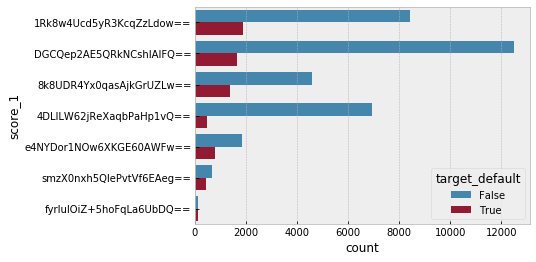

In [18]:
sns.countplot(y='score_1',hue='target_default', data=acq_train)

Por este motivo, fazemos também *label encoding* nesta variável, a fim de que possa ser escolhida pelo modelo.

In [19]:
train_ohe['score_1'] = train_ohe['score_1'].astype('category').cat.codes
test_ohe['score_1'] = test_ohe['score_1'].astype('category').cat.codes

# Modelagem

## Seleção de *features*

Definimos como target a variável binária de inadimplência, como dito anteriormente, e utilizamos um conjunto de variáveis como possibilidade para o modelo. Então treinamos um modelo simples de RandomForest e vemos quais são as principais features consideradas.

In [20]:
target = 'target_default'
all_variables =  continuous + discrete + one_hot_cat + ['score_1', 'facebook_profile', target]
input_only = [v for v in all_variables if v != target]

In [21]:
def get_feature_importance_df(feature_importances, 
                              column_names, 
                              top_n=25):
    """Get feature importance data frame.
 
    Parameters
    ----------
    feature_importances : numpy ndarray
        Feature importances computed by an ensemble 
            model like random forest or boosting
    column_names : array-like
        Names of the columns in the same order as feature 
            importances
    top_n : integer
        Number of top features
 
    Returns
    -------
    df : a Pandas data frame
 
    """
     
    imp_dict = dict(zip(column_names, 
                        feature_importances))
    top_features = sorted(imp_dict, 
                          key=imp_dict.get, 
                          reverse=True)[0:top_n]
    top_importances = [imp_dict[feature] for feature 
                          in top_features]
    df = pd.DataFrame(data={'feature': top_features, 
                            'importance': top_importances})
    return df

In [22]:
train = train_ohe[all_variables]

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=150, max_depth=8, min_samples_leaf=5, max_features=0.2, n_jobs=-1, random_state=42)
rf.fit(train.drop([target],axis=1), train[target])
features = train.drop([target],axis=1).columns.values

In [23]:
feature_importance = get_feature_importance_df(rf.feature_importances_, features)

O gráfico a seguir mostra as 10 variáveis mais importantes de acordo com o modelo:

[Text(0, 0.5, 'Nome da variável'),
 Text(0.5, 0, 'Importância'),
 Text(0.5, 1.0, 'Importância das variáveis')]

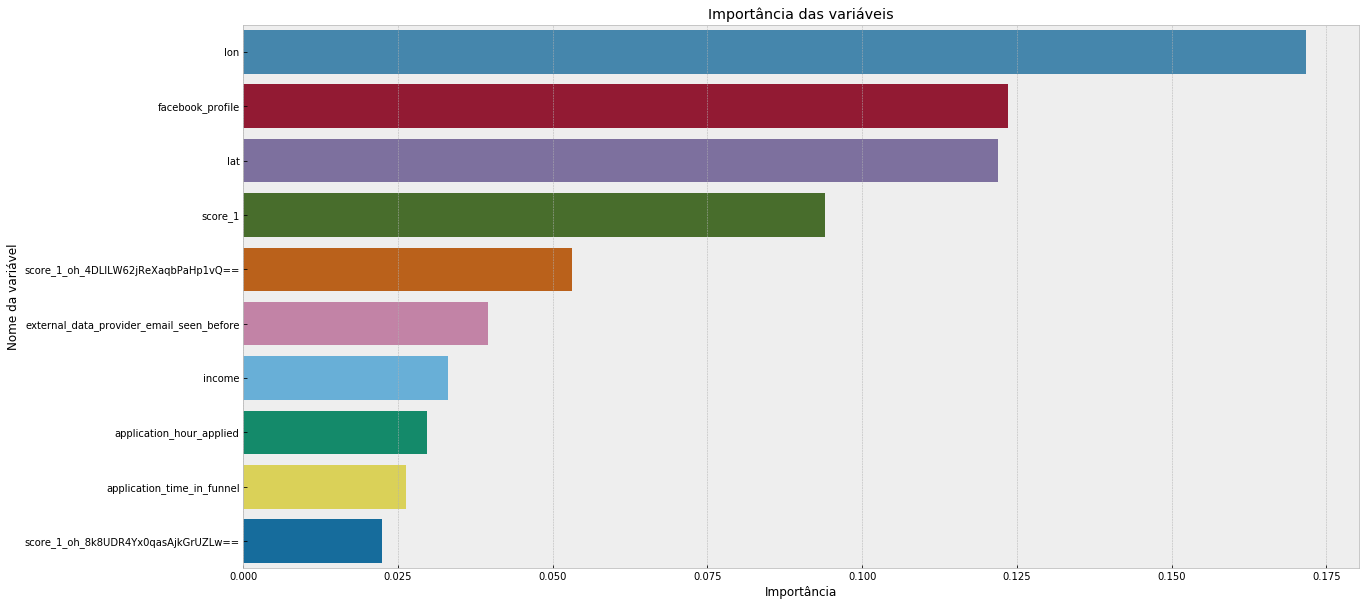

In [24]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)
sns.barplot(data=feature_importance[:10],y="feature",x="importance",ax=ax)
ax.set(ylabel='Nome da variável', xlabel='Importância',title="Importância das variáveis")

Note que aparecem `score_1` e duas variáveis criadas pelo one-hot encoding de `score_1`. 
Para evitar redundância no modelo, vamos deixar somente `score_1` e eliminar as variáveis de one-hot encoding.

In [25]:
all_variables = continuous + discrete + ['score_1', 'facebook_profile', target]
input_only = [v for v in all_variables if v != target]

In [26]:
train = train_ohe[all_variables]

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=150, max_depth=8, min_samples_leaf=5, max_features=0.2, n_jobs=-1, random_state=42)
rf.fit(train.drop([target],axis=1), train[target])
features = train.drop([target],axis=1).columns.values

In [27]:
feature_importance = get_feature_importance_df(rf.feature_importances_, features)

O gráfico a seguir mostra as 10 variáveis mais importantes de acordo com o modelo:

[Text(0, 0.5, 'Nome da variável'),
 Text(0.5, 0, 'Importância'),
 Text(0.5, 1.0, 'Importância das variáveis')]

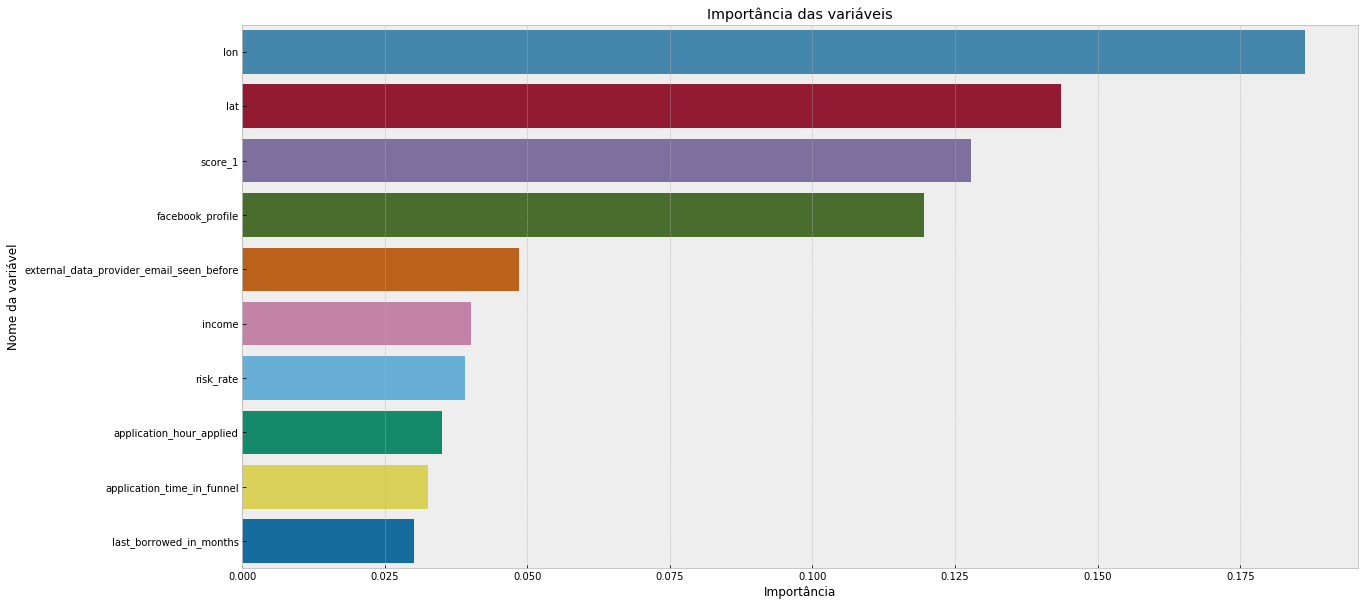

In [28]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)
sns.barplot(data=feature_importance[:10],y="feature",x="importance",ax=ax)
ax.set(ylabel='Nome da variável', xlabel='Importância',title="Importância das variáveis")

Utilizaremos estas variáveis no nosso modelo final.

In [29]:
variables = feature_importance[:10].feature.tolist()

In [30]:
def cross_val_model(X,y, model, n_splits=5):
    from sklearn.model_selection import StratifiedKFold
    from sklearn.model_selection import cross_val_score
    X = np.array(X)
    y = np.array(y)


    folds = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42).split(X, y))

    for j, (train_idx, test_idx) in enumerate(folds):
        X_train = X[train_idx]
        y_train = y[train_idx]
        X_holdout = X[test_idx]
        y_holdout = y[test_idx]

        print ("Fit %s fold %d" % (str(model).split('(')[0], j+1))
        model.fit(X_train, y_train)
        cross_score = cross_val_score(model, X_holdout, y_holdout, cv=3, scoring='roc_auc')
        print("    cross_score: %.5f" % cross_score.mean())

Escolhemos `StratifiedKFold` e a métrica `roc_auc` por se tratar de um conjunto enviesado, como visto na exploração dos dados. Em outras palavras, as classes possíveis para o alvo não estão balanceadas.

Definimos a seguir `X` e `y` para os modelos.

In [31]:
train_ohe['facebook_profile'] = train_ohe['facebook_profile'].astype(np.int)
test_ohe['facebook_profile'] = test_ohe['facebook_profile'].astype(np.int)
X = train_ohe[variables]
y = train_ohe[target]

## Modelo - RandomForest

Implementamos a seguir um modelo de RandomForest para classificação.

In [32]:
#RandomForest params
rf_params = {}
rf_params['n_estimators'] = 200
rf_params['max_depth'] = 8
rf_params['min_samples_split'] = 70
rf_params['min_samples_leaf'] = 30

rf_model = RandomForestClassifier(**rf_params)

In [33]:
cross_val_model(X, y, rf_model)

Fit RandomForestClassifier fold 1
    cross_score: 0.72296
Fit RandomForestClassifier fold 2
    cross_score: 0.72692
Fit RandomForestClassifier fold 3
    cross_score: 0.72300
Fit RandomForestClassifier fold 4
    cross_score: 0.72326
Fit RandomForestClassifier fold 5
    cross_score: 0.71850


### Otimização de parâmetros

Uma vez que temos o modelo pronto, vamos tentar otimizar alguns parâmetros do modelo.

In [34]:
from sklearn.model_selection import GridSearchCV

rf_model = RandomForestClassifier()

rf_grid_params= {'n_estimators':[200,250],
                 'max_depth':[8,10,12,15], 
                 'min_samples_leaf': [10,20,30,40], 
                 'min_samples_split':[50,60,70,80]}

rf_grid = GridSearchCV(rf_model,rf_grid_params,scoring='roc_auc')

In [35]:
run_gs = False
if run_gs:
    rf_best = rf_grid.fit(X,y)
    rf_model = rf_best.best_estimator_
else:
    rf_best_params = {'max_depth': 8,
     'min_samples_leaf': 30,
     'min_samples_split': 70,
     'n_estimators': 250}
    rf_model = RandomForestClassifier(**rf_best_params)
    
rf_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=30, min_samples_split=70,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [36]:
cross_val_model(X, y, rf_model)

Fit RandomForestClassifier fold 1
    cross_score: 0.72380
Fit RandomForestClassifier fold 2
    cross_score: 0.72664
Fit RandomForestClassifier fold 3
    cross_score: 0.72170
Fit RandomForestClassifier fold 4
    cross_score: 0.72440
Fit RandomForestClassifier fold 5
    cross_score: 0.71801


Percebemos que os scores não melhoraram muito. Vamos testar outro modelo.

## Modelo - LightGBM

Implementamos a seguir um modelo LightGBM para classificação.

In [37]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

lgb_params = {"objective": "binary",
          "boosting_type": "gbdt",
          "learning_rate": 0.1,
          "num_leaves": 15,
           "max_bin": 256,
          "verbosity": 0,
          "drop_rate": 0.1,
          "is_unbalance": True,
          "max_drop": 50,
          "min_child_samples": 10,
          "min_child_weight": 150,
          "min_split_gain": 15,
          "subsample": 0.9
          }

In [38]:
lgb_model = lgb.LGBMClassifier(**lgb_params)
cross_val_model(X,y,lgb_model)

Fit LGBMClassifier fold 1
    cross_score: 0.73470
Fit LGBMClassifier fold 2
    cross_score: 0.73279
Fit LGBMClassifier fold 3
    cross_score: 0.73521
Fit LGBMClassifier fold 4
    cross_score: 0.73635
Fit LGBMClassifier fold 5
    cross_score: 0.72522


### Otimização de parâmetros

Com o modelo pronto, vamos tentar otimizar alguns parâmetros do modelo.

In [39]:
from sklearn.model_selection import GridSearchCV

lgb_X_train = lgb.Dataset(X, label=y)
lgb_model = lgb.LGBMClassifier(**lgb_params)

lgb_grid_params = {"objective": ["binary"],
          "boosting_type": ["gbdt"],
          "learning_rate": [0.02,0.05,0.1],
          "num_leaves": [10,15,20],
           "max_bin": [256],
          "verbosity": [0],
          "drop_rate": [0.1],
          "is_unbalance": [True],
          "max_drop": [40,50,60],
          "min_child_samples": [10],
          "min_child_weight": [100,150],
          "min_split_gain": [15],
          "subsample": [0.7,0.9],
          "n_estimators":[150,200,250]
          }

lgb_grid = GridSearchCV(lgb_model,lgb_grid_params,scoring='roc_auc')

In [40]:
run_gs = False
if run_gs:
    lgb_best = lgb_grid.fit(X,y)
    lgb_model = lgb_grid.best_estimator_
else:
    lgb_best_params = {'boosting_type': 'gbdt',
 'drop_rate': 0.1,
 'is_unbalance': True,
 'learning_rate': 0.05,
 'max_bin': 256,
 'max_drop': 40,
 'min_child_samples': 10,
 'min_child_weight': 100,
 'min_split_gain': 15,
 'n_estimators': 150,
 'num_leaves': 10,
 'objective': 'binary',
 'subsample': 0.7,
 'verbosity': 0}
    
    lgb_model = lgb.LGBMClassifier(**lgb_best_params)
    
lgb_model

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        drop_rate=0.1, is_unbalance=True, learning_rate=0.05, max_bin=256,
        max_depth=-1, max_drop=40, min_child_samples=10,
        min_child_weight=100, min_split_gain=15, n_estimators=150,
        n_jobs=-1, num_leaves=10, objective='binary', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=0, verbosity=0)

In [41]:
cross_val_model(X, y, lgb_model)

Fit LGBMClassifier fold 1
    cross_score: 0.73858
Fit LGBMClassifier fold 2
    cross_score: 0.73346
Fit LGBMClassifier fold 3
    cross_score: 0.73545
Fit LGBMClassifier fold 4
    cross_score: 0.73697
Fit LGBMClassifier fold 5
    cross_score: 0.72594


## Análise do resultado

Analisamos a seguir como fica a distribuição dos valores da predição no próprio conjunto de treino, para termos uma noção de como cada modelo performa. Criamos ainda um outro campo de predição, `pred_comb`, com a média dos dois modelos.

In [42]:
train_pred = train_ohe.copy()
X_pred = train_ohe[variables]
train_pred['pred_rf'] = rf_model.predict_proba(X_pred)[:,1]
train_pred['pred_lgb'] = lgb_model.predict_proba(X_pred)[:,1]

train_pred['pred_comb'] = 0.5*train_pred['pred_rf'] + 0.5*train_pred['pred_lgb']

Vejamos as distribuições.

Text(0.5, 0, 'Probabilidades')

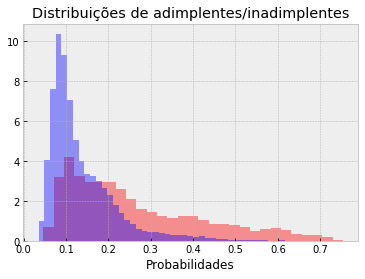

In [43]:
sns.distplot(train_pred[train_pred[target]==True].pred_rf, norm_hist=True, kde=False, color='r')
sns.distplot(train_pred[train_pred[target]==False].pred_rf, norm_hist=True, kde=False, color='b')
plt.title('Distribuições de adimplentes/inadimplentes')
plt.xlabel('Probabilidades')

Text(0.5, 0, 'Probabilidades')

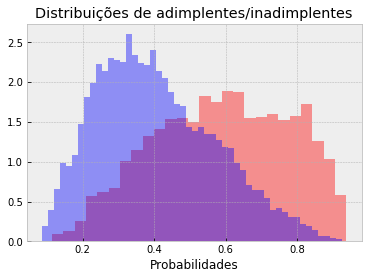

In [44]:
sns.distplot(train_pred[train_pred[target]==True].pred_lgb, norm_hist=True, kde=False, color='r')
sns.distplot(train_pred[train_pred[target]==False].pred_lgb, norm_hist=True, kde=False, color='b')
plt.title('Distribuições de adimplentes/inadimplentes')
plt.xlabel('Probabilidades')

Como podemos observar, o modelo de RandomForest faz um bom trabalho em manter os casos adimplentes 
à esquerda, com probabilidade próxima a zero, o que não ocorre no segundo gráfico. Já o modelo LGB consegue manter
altas as probabilidades para casos de inadimplência. Tomamos então como resultado a média dos dois, representado abaixo, de modo a tornar o modelo mais robusto.

Text(0.5, 0, 'Probabilidades')

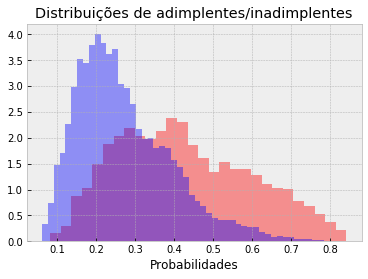

In [45]:
sns.distplot(train_pred[train_pred[target]==True].pred_comb, norm_hist=True, kde=False, color='r')
sns.distplot(train_pred[train_pred[target]==False].pred_comb, norm_hist=True, kde=False, color='b')
plt.title('Distribuições de adimplentes/inadimplentes')
plt.xlabel('Probabilidades')

## Saída

In [46]:
output = pd.DataFrame(columns=['ids','default'])
output['ids'] = test_ohe['ids'].values
output_rf = rf_model.predict_proba(test_ohe[variables])[:,1]
output_lgb = lgb_model.predict_proba(test_ohe[variables])[:,1]
output['default'] = 0.5*output_rf + 0.5*output_lgb
output.to_csv('default.csv', index=False)